# Tour of the Advanced Interface


In this notebook we will go over some of the basic workflow to create a a surrogate model from an EnergyPlus simulation. We will train a neural network to find daily electricity output based on window to wall ratio and solar gain coefficient. Finally we will use this surrogate model to do an optimization of the building. 

![Image](image/flow_diagram.PNG) 

In [1]:
#!pip install besos --user
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.objectives import MeterReader,time_series_values,EPResults

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from platypus.evaluator import MapEvaluator
import time
from dask.distributed import Client


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Use seaborn for pairplot
#!pip install --upgrade tensorflow --user

# Use some functions from tensorflow_docs
#!pip install git+https://github.com/tensorflow/docs --user

# (1) Set up the building from idf

In [ ]:
# Open the IDF file
building = ef.get_building("Medium_Office.idf")

# (2) Set up the outputs and inputs

In [5]:
# Setup the parameters
parameters = [Parameter(FieldSelector('Window',"*",'Solar Heat Gain Coefficient'),
                value_descriptor=RangeParameter(0.01,0.99),
                name='Solar Gain Coefficient')]

# Add window-to-wall ratio as a parameter between 0.1 and 0.9 using a custom function
parameters.append(wwr(RangeParameter(0.1, 0.9))) 

def data_to_array(results: EPResults):
    # to make sure we get the hourly values we have to make our 
    # own function to return the array without summing them which
    # is the default in besos. 
    return results.data["Value"].values
# Construct the objective
objective = [MeterReader(key_name='Electricity:Facility',func=data_to_array, frequency='Daily')]
# Build the problem
problem = EPProblem(parameters, objective)
# setup the evaluator
evaluator = EvaluatorEP(problem, building, epw_file = "victoria.epw", multi=True)

,Solar Gain Coefficient,Window to Wall Ratio
0,0.409048,0.867502
1,0.514402,0.294700
2,0.303002,0.289754
3,0.603238,0.797945
4,0.217869,0.567174


In [4]:
# Construct the evaluator, here we also add the epw file such that we have 
# weather data for an entire year. 
evaluator = EvaluatorEP(problem, building, epw_file = "victoria.epw")
# Run Energyplus
outputs = evaluator.df_apply(inputs.head(1))

# Build a results DataFrame
results = inputs.head(1).join(outputs)
print(results.head())


   Solar Gain Coefficient  Window to Wall Ratio  \
0                0.284395              0.571603   

                                 Heating:Electricity  
0  [108152877.68161495, 3540938357.8196387, 25072...  


In [4]:
client = Client(threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:43091 Dashboard: /user/theochri/proxy/8787/status,Cluster Workers: 16 Cores: 16 Memory: 34.36 GB


In [6]:
# Use latin hypercube sampling to take 30 samples
inputs = sampling.dist_sampler(sampling.lhs, problem,100)
# sample of the inputs
print(inputs.head())


t1=time.time()
# Run Energyplus
outputs = evaluator.df_apply(inputs)
t2=time.time()
time_of_sim=t2-t1

/usr/local/lib/python3.7/dist-packages/distributed/worker.py:3339: UserWarning: Large object of size 5.35 MB detected in task graph: 
  ("('from_pandas-55883064fd10d21f3b67707184a5d32a', ... 7707184a5d32a')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [7]:
def niceformat(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds 

hours,mins,secs=niceformat(time_of_sim)

print("the total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(hours,mins,secs))
# Build a results DataFrame

the total running time:  0 hours 35 min 29 seconds


In [8]:
results = inputs.join(outputs)
results.head()

,Solar Gain Coefficient,Window to Wall Ratio,Electricity:Facility
0,0.409048,0.867502,"[1180684035.3518057, 9794487272.569838, 897383..."
1,0.514402,0.294700,"[997994614.8944771, 7712055085.092192, 6851805..."
2,0.303002,0.289754,"[997820334.2064877, 7692209596.335068, 6833267..."
3,0.603238,0.797945,"[1160853156.1022706, 9641777706.005512, 878553..."
4,0.217869,0.567174,"[1104317113.8278315, 8992140272.141285, 792529..."


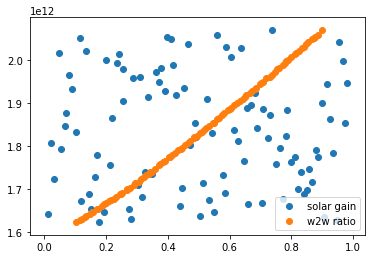

In [9]:
total_heating_use = [sum(hourly_data) for hourly_data in results['Electricity:Facility']]
plt.scatter(results['Solar Gain Coefficient'],total_heating_use,label="solar gain")
plt.scatter(results['Window to Wall Ratio'],total_heating_use,label="w2w ratio")
plt.legend()

# (3) Store the expensive runs

Since this can quite a big run. Lets store the results such that we don't have to rerun this problem.

In [10]:
inputs.to_pickle("inputs.pkl")
outputs.to_pickle("outputs.pkl")

In [11]:
inputs_ = pd.read_pickle("inputs.pkl")
outputs_ = pd.read_pickle("outputs.pkl")

# (4) Reload the expensive runs

The outputs are packed in a single columns which will not work for tensorflow.

In [12]:
print(outputs_.head())
print(inputs_.head())

                                Electricity:Facility
0  [1180684035.3518057, 9794487272.569838, 897383...
1  [997994614.8944771, 7712055085.092192, 6851805...
2  [997820334.2064877, 7692209596.335068, 6833267...
3  [1160853156.1022706, 9641777706.005512, 878553...
4  [1104317113.8278315, 8992140272.141285, 792529...
   Solar Gain Coefficient  Window to Wall Ratio
0                0.409048              0.867502
1                0.514402              0.294700
2                0.303002              0.289754
3                0.603238              0.797945
4                0.217869              0.567174


We will repack them using the following code, to get 365 different columns which will represent the output labels. Build the full dataset with inputs and outputs to easily split up the train and test data sets. The training data sets are used to train the model, while the test data set will show how general the model is. 

In [13]:
newarray = []
for i in range(len(outputs_)):
    newarray.append(outputs_.iloc[i].values[0])
outputs1= pd.DataFrame(newarray)
outputs1.head()
dataset=inputs_.join(outputs1)
dataset.head()

,Solar Gain Coefficient,Window to Wall Ratio,0,1,2,3,4,5,6,7,...,355,356,357,358,359,360,361,362,363,364
0,0.409048,0.867502,1.180684e+09,9.794487e+09,8.973834e+09,8.547405e+09,7.804733e+09,7.343356e+09,9.976628e+08,9.977353e+08,...,7.708081e+09,9.975005e+08,9.973982e+08,8.516846e+09,8.089685e+09,8.366126e+09,7.949139e+09,7.803754e+09,9.974593e+08,1.013826e+09
1,0.514402,0.294700,9.979946e+08,7.712055e+09,6.851805e+09,6.590209e+09,6.192442e+09,5.991938e+09,9.976680e+08,9.976184e+08,...,6.049578e+09,1.000246e+09,9.974739e+08,6.527792e+09,6.306929e+09,6.373976e+09,6.255888e+09,6.347743e+09,9.975987e+08,9.974088e+08
2,0.303002,0.289754,9.978203e+08,7.692210e+09,6.833267e+09,6.571380e+09,6.177266e+09,5.979638e+09,9.976284e+08,9.976727e+08,...,6.031276e+09,1.000302e+09,9.981655e+08,6.508936e+09,6.290137e+09,6.354309e+09,6.238857e+09,6.331877e+09,9.973166e+08,9.974008e+08
3,0.603238,0.797945,1.160853e+09,9.641778e+09,8.785539e+09,8.351021e+09,7.645301e+09,7.208107e+09,9.976615e+08,9.977325e+08,...,7.529691e+09,9.974958e+08,9.974058e+08,8.305864e+09,7.850457e+09,8.145049e+09,7.763735e+09,7.577235e+09,9.974420e+08,1.002615e+09
4,0.217869,0.567174,1.104317e+09,8.992140e+09,7.925292e+09,7.522446e+09,7.043759e+09,6.729074e+09,9.976887e+08,9.976459e+08,...,6.869358e+09,9.974963e+08,9.973632e+08,7.487892e+09,7.137860e+09,7.284860e+09,7.060074e+09,7.057108e+09,9.974177e+08,9.974122e+08


# Split dataset into test and training

In [14]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

training_labels = train_dataset[outputs1.columns]
testing_labels = test_dataset[outputs1.columns]

# Normalize the Data (Inputs of the model)

We will normalize the inputs and the outputs

In [15]:
train_stats = train_dataset[inputs_.columns]
train_stats = train_stats.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Solar Gain Coefficient,80.0,0.487432,0.277093,0.023025,0.250423,0.496899,0.732913,0.980224
Window to Wall Ratio,80.0,0.502732,0.227329,0.101517,0.310225,0.488787,0.698923,0.899728


In [16]:

# use the stats we calculated to do the normalization on the input.
def norm_input(x):
    return (x - train_stats['mean']) / train_stats['std']

def unnorm_input(x):
    return (x* train_stats['std'])+ train_stats['mean']

normed_train_data = norm_input(train_dataset[inputs_.columns])
normed_test_data = norm_input(test_dataset[inputs_.columns])


print(test_dataset[inputs_.columns])
print(normed_test_data)
print(unnorm_input(normed_test_data))

    Solar Gain Coefficient  Window to Wall Ratio
9                 0.254017              0.755052
12                0.360217              0.747770
21                0.473182              0.454078
25                0.704983              0.201176
36                0.151424              0.170771
37                0.897690              0.625471
39                0.491204              0.485777
44                0.858404              0.357274
46                0.660753              0.194162
47                0.615229              0.517644
58                0.279372              0.122512
64                0.012475              0.146916
65                0.689488              0.524241
67                0.955198              0.854760
70                0.090509              0.681342
81                0.241696              0.811715
83                0.451104              0.684923
87                0.949360              0.115583
88                0.966814              0.783163
96                0.

# Normalize the labels (Outputs of the model)

labels are the actual outputs that we are interested in. 

In [17]:
train_mean = np.mean(np.mean(training_labels))
train_std  = np.std(np.mean(testing_labels))
train_mean, train_std

(5024034735.494545, 2574679772.2126355)

In [18]:
def norm_output(x):
    return (x - train_mean) /train_std

def unnorm_output(x):
    return (x*train_std)+ train_mean

train_labels = norm_output(training_labels)
test_labels  = norm_output(testing_labels)
train_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
26,-1.509163,1.746898,1.390555,1.252422,0.986613,0.823997,-1.563834,-1.563806,1.370453,1.006334,...,0.941145,-1.563898,-1.563935,1.236702,1.065521,1.173619,1.011012,0.962452,-1.563919,-1.562999
86,-1.563845,0.964321,0.653331,0.551382,0.377804,0.344291,-1.563845,-1.563833,0.595382,0.376755,...,0.346831,-1.563902,-1.563920,0.493613,0.429682,0.442845,0.427357,0.439361,-1.563978,-1.563936
2,-1.563773,1.036313,0.702702,0.600986,0.447912,0.371154,-1.563847,-1.563830,0.648975,0.447658,...,0.391210,-1.562809,-1.563639,0.576732,0.491751,0.516676,0.471834,0.507963,-1.563969,-1.563936
55,-1.518276,1.628458,1.224673,1.070226,0.868754,0.720718,-1.563836,-1.563835,1.179232,0.846891,...,0.809488,-1.563932,-1.563904,1.058753,0.909489,0.985161,0.879502,0.868476,-1.563917,-1.563930
75,-1.525609,1.475056,1.056632,0.899410,0.724156,0.629121,-1.563839,-1.563841,0.989428,0.705057,...,0.655046,-1.563908,-1.563924,0.884078,0.758546,0.800575,0.697519,0.742067,-1.563953,-1.563932


# (5) Build model

In [19]:
def build_model():
    model = keras.Sequential([
       layers.Dense(4, input_shape=[len(train_dataset[inputs_.columns].keys())]),
       layers.Dense(16),
       layers.Dense(365),
       layers.Dense(365)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.00005)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [20]:
model = build_model()

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 365)               6205      
_________________________________________________________________
dense_3 (Dense)              (None, 365)               133590    
Total params: 139,887
Trainable params: 139,887
Non-trainable params: 0
_________________________________________________________________


# Train surrogate model

In [22]:
EPOCHS = 2000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.0684,  mae:0.8998,  mse:1.0684,  val_loss:1.0975,  val_mae:0.9052,  val_mse:1.0975,  
....................................................................................................
Epoch: 100, loss:0.9498,  mae:0.8610,  mse:0.9498,  val_loss:0.9679,  val_mae:0.8730,  val_mse:0.9679,  
....................................................................................................
Epoch: 200, loss:0.7942,  mae:0.7696,  mse:0.7942,  val_loss:0.8067,  val_mae:0.7790,  val_mse:0.8067,  
....................................................................................................
Epoch: 300, loss:0.5514,  mae:0.5975,  mse:0.5514,  val_loss:0.5559,  val_mae:0.6021,  val_mse:0.5559,  
....................................................................................................
Epoch: 400, loss:0.2859,  mae:0.3564,  mse:0.2859,  val_loss:0.2842,  val_mae:0.3552,  val_mse:0.2842,  
........................................................................

In [23]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'loss')

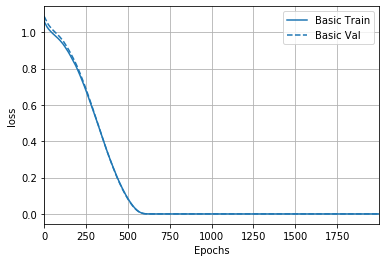

In [24]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylabel('loss')

(0, 10000000000)

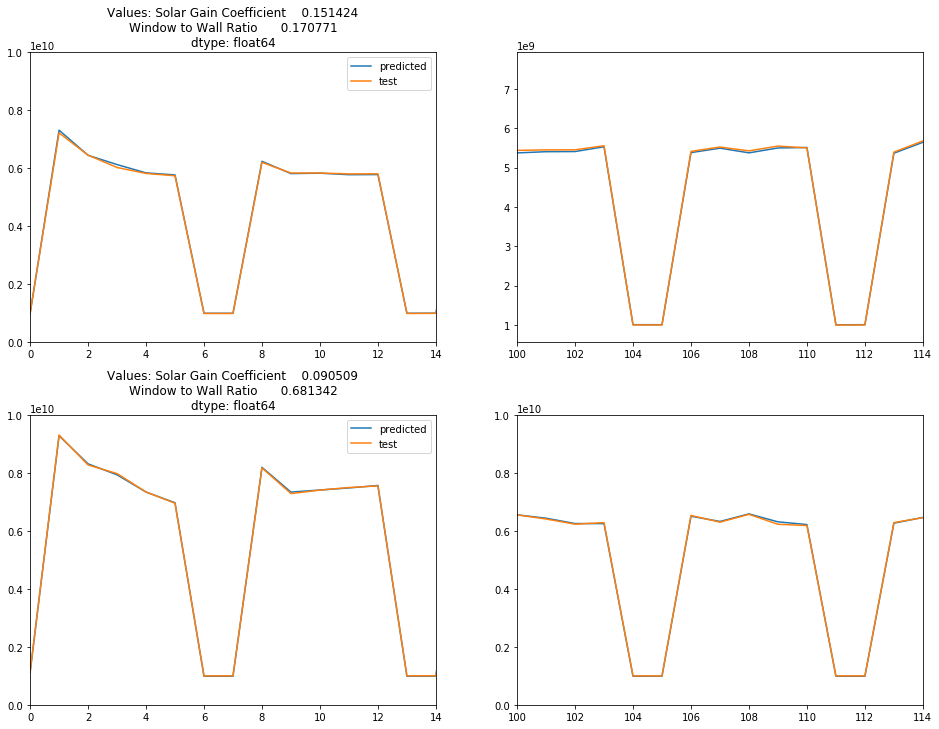

In [49]:
test_num=4
values = [normed_test_data.loc[normed_test_data.index[test_num],:].tolist()]
test_predictions = model.predict(values)
predicted_timeseries=unnorm_output(test_predictions[0])
test_timeseries = unnorm_output(test_labels.loc[test_labels.index[test_num]])


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,12))
fig.subplots_adjust(hspace=0.25)
ax1.set_title('Values: {}'.format(unnorm_input(values[0])))

ax1.plot(predicted_timeseries,label='predicted')
ax1.plot(test_timeseries,label='test')
ax1.legend()
ax1.set_xlim([0,14])
ax1.set_ylim([0,10**10])
ax2.plot(predicted_timeseries)
ax2.plot(test_timeseries)
ax2.set_xlim([100,114])

test_num=14
values = [normed_test_data.loc[normed_test_data.index[test_num],:].tolist()]
test_predictions = model.predict(values)
predicted_timeseries=unnorm_output(test_predictions[0])
test_timeseries = unnorm_output(test_labels.loc[test_labels.index[test_num]])

ax3.set_title('Values: {}'.format(unnorm_input(values[0])))
ax3.plot(predicted_timeseries,label='predicted')
ax3.plot(test_timeseries,label='test')
ax3.legend()
ax3.set_xlim([0,14])
ax3.set_ylim([0,10**10])
ax4.plot(predicted_timeseries)
ax4.plot(test_timeseries)
ax4.set_xlim([100,114])
ax4.set_ylim([0,10**10])

0.9997646208835901

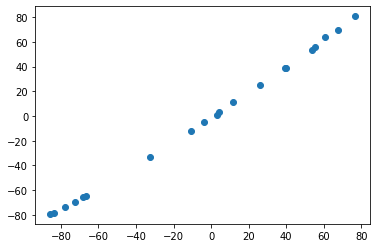

In [26]:
# See -> https://en.wikipedia.org/wiki/Coefficient_of_determination
# R squared score:
r_sqared_scores = []
sum_res_s = []
sum_tot_s = []
for i in range(len(normed_test_data)):
    x_i = normed_test_data.loc[normed_test_data.index[i]].tolist()
    f_i = model.predict([x_i])[0]
    y_i = test_labels.loc[test_labels.index[i]].values
    y_m = np.mean(y_i)/y_i.size
    ss_res=sum((f_i-y_i)**2)
    ss_tot=sum((y_i-y_m)**2)
    sum_res_s.append(sum(f_i))
    sum_tot_s.append(sum(y_i))
    r_sqared_scores.append(1-ss_res/ss_tot)

plt.scatter(sum_res_s,sum_tot_s)
np.mean(r_sqared_scores)

# (7) Optimize the surrogate model.

In [27]:
def building_surrogate_model(values): 
    # First normalize the input values
    values = norm_input(values)
    # predict the time series
    test_predictions = unnorm_output(model.predict([values.to_list()])[0])
    # calculate the total electricity use
    total_electricity_use = sum(test_predictions)
    # calculate the std electricity use
    std_electricity_use = np.std(test_predictions)
    # output the objectives using the besos format:
    # ((objectives),(constraints))
    return ((total_electricity_use, std_electricity_use), ())

# lets do a quick check 

In [28]:
building_surrogate_model((0.5,0.5))

((1831596733184.0, 2580589600.0), ())

# (8) Set up the optimization

In [29]:
from besos.evaluator import EvaluatorSR,EvaluatorGeneric
from besos.parameters import RangeParameter, wwr, FieldSelector, Parameter
from besos.objectives import MeterReader, VariableReader, clear_outputs
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Setup the parameters
SRparameters = [Parameter(value_descriptor=RangeParameter(0.01,0.99),name='Solar Gain Coefficient'),
                Parameter(value_descriptor=RangeParameter(0.1,0.9),name='Window to Wall Ratio')]

SRobjectives = ['total_electricity', 'std_electricity']
BuildingProblem = Problem(inputs=SRparameters,outputs=SRobjectives,minimize_outputs=[False,True])

In [30]:
BuildingEvaluator = EvaluatorGeneric(building_surrogate_model, BuildingProblem)

In [31]:
GeneticAlgoResults = NSGAII(BuildingEvaluator, evaluations=1000, population_size=10)
GeneticAlgoResults

,Solar Gain Coefficient,Window to Wall Ratio,total_electricity,std_electricity,violation,pareto-optimal
0,0.989616,0.100000,1.604540e+12,2.199744e+09,0,True
1,0.215732,0.900000,2.058166e+12,2.986742e+09,0,True
2,0.219313,0.328711,1.735530e+12,2.419476e+09,0,True
3,0.848721,0.241110,1.684564e+12,2.329649e+09,0,True
4,0.811006,0.494325,1.827654e+12,2.571193e+09,0,True
5,0.986614,0.636448,1.907499e+12,2.709456e+09,0,True
6,0.803755,0.464248,1.810685e+12,2.541998e+09,0,True
7,0.989009,0.706300,1.946941e+12,2.779575e+09,0,True
8,0.958365,0.805464,2.003015e+12,2.880667e+09,0,True
9,0.989009,0.153245,1.634611e+12,2.247501e+09,0,True


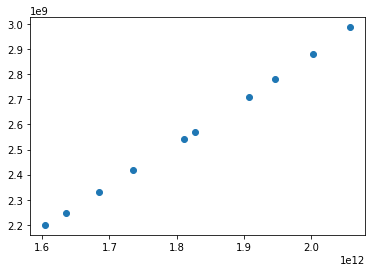

In [32]:
plt.scatter(GeneticAlgoResults["total_electricity"],GeneticAlgoResults["std_electricity"])

In [33]:
from besos.evaluator import EvaluatorSR,EvaluatorGeneric
from besos.parameters import RangeParameter, wwr, FieldSelector, Parameter
from besos.objectives import MeterReader, VariableReader, clear_outputs
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

In [34]:
def building_surrogate_model(values): 
    # First normalize the input values
    values = norm_input(values)
    # predict the time series
    test_predictions = unnorm_output(model.predict([values.to_list()])[0])
    # calculate the total electricity use
    winter_electricity_use = sum(test_predictions[0:int(365/4)]) + sum(test_predictions[int(365*3/4):364] )
    # calculate the std electricity use
    summer_electricity_use = sum(test_predictions[int(365/4):int(365*3/4)])
    # output the objectives using the besos format:
    # ((objectives),(constraints))
    return ((winter_electricity_use, summer_electricity_use), ())

# Setup the parameters
SRparameters = [Parameter(value_descriptor=RangeParameter(0.01,0.99),name='Solar Gain Coefficient'),
                Parameter(value_descriptor=RangeParameter(0.1,0.9),name='Window to Wall Ratio')]

SRobjectives = ['winter_use', 'summer_use']
BuildingProblem = Problem(inputs=SRparameters,outputs=SRobjectives,minimize_outputs=[True,False])

BuildingEvaluator = EvaluatorGeneric(building_surrogate_model, BuildingProblem)

GeneticAlgoResults = NSGAII(BuildingEvaluator, evaluations=1000, population_size=20)
GeneticAlgoResults

,Solar Gain Coefficient,Window to Wall Ratio,winter_use,summer_use,violation,pareto-optimal
0,0.224167,0.899732,1.062440e+12,9.945686e+11,0,True
1,0.370712,0.100001,7.731342e+11,8.318670e+11,0,True
2,0.305090,0.420227,8.889782e+11,8.970309e+11,0,True
3,0.336050,0.333129,8.574677e+11,8.792777e+11,0,True
4,0.243098,0.759966,1.011880e+12,9.661488e+11,0,True
5,0.430595,0.275791,8.367119e+11,8.674254e+11,0,True
6,0.300919,0.796904,1.025232e+12,9.735195e+11,0,True
7,0.142886,0.570871,9.434965e+11,9.279788e+11,0,True
8,0.162824,0.666111,9.779438e+11,9.472716e+11,0,True
9,0.275100,0.627996,9.641383e+11,9.392826e+11,0,True


# (9) Optimal Building

Text(0, 0.5, 'summer_use')

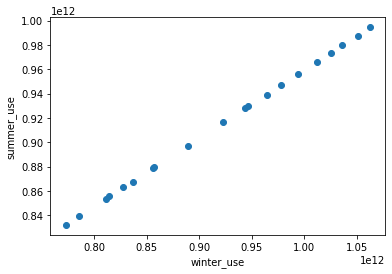

In [35]:
plt.scatter(GeneticAlgoResults["winter_use"],GeneticAlgoResults["summer_use"])
plt.xlabel("winter_use")
plt.ylabel("summer_use")